# Synthetic Controls

### When should we use SC?
- Single, large treated unit
- No clear control group

### What is the main idea?
- Using units not treated, we can construct a surrogate control unit that serves as a comparision group. 

### When can we use SC?
- Outcome should not be too volatile
- Control units should not have any interventions applied to them, and some of them should be largely similar to the treated
- No anticipation
- No spillovers
- SC must be a good fit in the pre-period
- Sufficient data in the post period to see the full impact


,state,year,cigsale,lnincome,beer,age15to24,retprice
0,Alabama,1970,89.8,NaN,NaN,0.178862,39.6
1,Alabama,1971,95.4,NaN,NaN,0.179928,42.7
2,Alabama,1972,101.1,9.498476,NaN,0.180994,42.3
3,Alabama,1973,102.9,9.550107,NaN,0.182060,42.1
4,Alabama,1974,108.2,9.537163,NaN,0.183126,43.1


year,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
state,,,,,,,,,,,,,,,,,,,,,
Alabama,89.8,95.4,101.1,102.9,108.2,111.7,116.2,117.1,123.0,121.4,...,107.9,109.1,108.5,107.1,102.6,101.4,104.9,106.2,100.7,96.2
Arkansas,100.3,104.1,103.9,108.0,109.7,114.8,119.1,122.6,127.3,126.5,...,116.8,126.0,113.8,108.8,113.0,110.7,108.7,109.5,104.8,99.4
California,123.0,121.0,123.5,124.4,126.7,127.1,128.0,126.4,126.1,121.9,...,68.7,67.5,63.4,58.6,56.4,54.5,53.8,52.3,47.2,41.6
Colorado,124.8,125.5,134.3,137.9,132.8,131.0,134.2,132.0,129.2,131.5,...,90.2,88.3,88.6,89.1,85.4,83.1,81.3,81.2,79.6,73.0
Connecticut,120.0,117.6,110.8,109.3,112.4,110.2,113.4,117.3,117.5,117.4,...,86.7,83.5,79.1,76.6,79.3,76.0,75.9,75.5,73.4,71.4


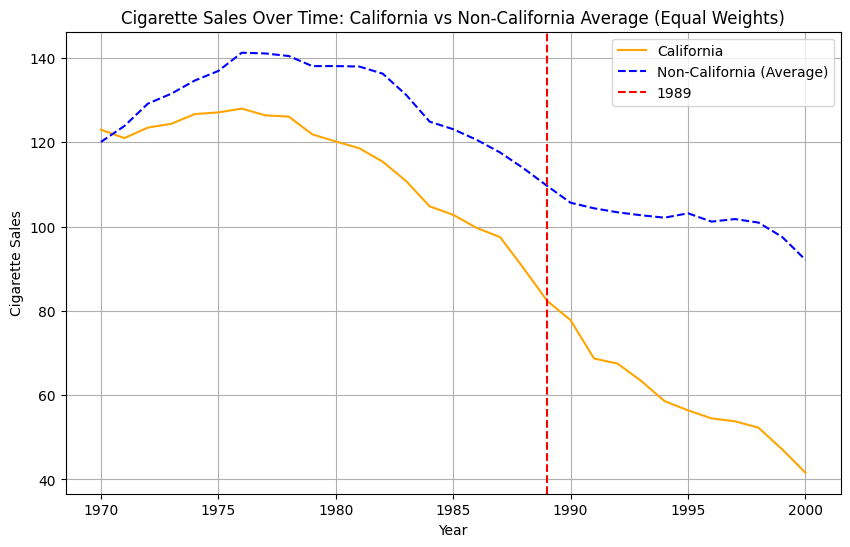

In [28]:
import pandas as pd
import warnings 
warnings.filterwarnings('ignore')
path = 'data/california99.csv'
df = pd.read_csv(path)
display(df.head())

pivot_df = df.pivot(index='state', columns='year', values='cigsale')
display(pivot_df.head())

non_california_avg = pivot_df.drop(index='California').mean()
plt.figure(figsize=(10, 6))
plt.plot(pivot_df.columns, pivot_df.loc['California'], label='California', color='orange')
plt.plot(pivot_df.columns, non_california_avg, label='Non-California (Average)', color='blue', linestyle='--')
plt.axvline(x=1989, color='red', linestyle='--', label='1989')
plt.xlabel('Year')
plt.ylabel('Cigarette Sales')
plt.title('Cigarette Sales Over Time: California vs Non-California Average (Equal Weights)')
plt.grid(True)
plt.legend()
plt.show()

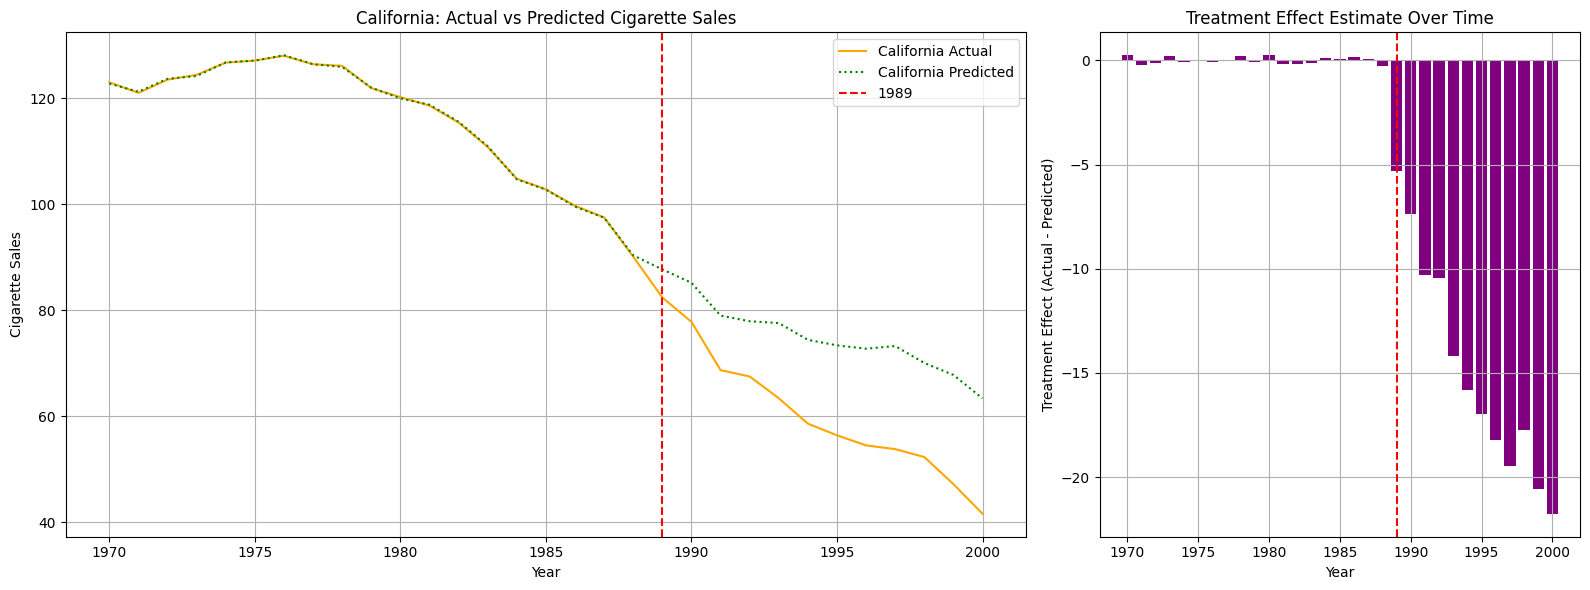

In [53]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

# Define pre-treatment years
treatment_year = 1989
pre_period_years = pivot_df.columns[pivot_df.columns < treatment_year]

# Prepare LASSO model data
X_pre = pivot_df.drop(index='California')[pre_period_years].T
y_pre = pivot_df.loc['California', pre_period_years].T

# Define regularization parameter and fit model
lambda_ = 0.1
lasso_model_final = Lasso(alpha=lambda_).fit(X_pre, y_pre)

# Predict synthetic control
california_predictions = lasso_model_final.predict(pivot_df.drop(index='California').T)

# Compute Treatment Effect Estimate (Actual - Predicted)
california_actual = pivot_df.loc['California'].values
treatment_effect = california_actual - california_predictions

# Create 1x2 grid of plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

# Plot 1: Actual vs Predicted Cigarette Sales
axes[0].plot(pivot_df.columns, california_actual, label='California Actual', color='orange')
axes[0].plot(pivot_df.columns, california_predictions, label='California Predicted', color='green', linestyle=':')
axes[0].axvline(x=1989, color='red', linestyle='--', label='1989')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Cigarette Sales')
axes[0].set_title('California: Actual vs Predicted Cigarette Sales')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Treatment Effect Estimate
axes[1].bar(pivot_df.columns, treatment_effect, color='purple')
axes[1].axvline(x=1989, color='red', linestyle='--', label='1989')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Treatment Effect (Actual - Predicted)')
axes[1].set_title('Treatment Effect Estimate Over Time')
axes[1].grid(True)

plt.tight_layout()
plt.show()


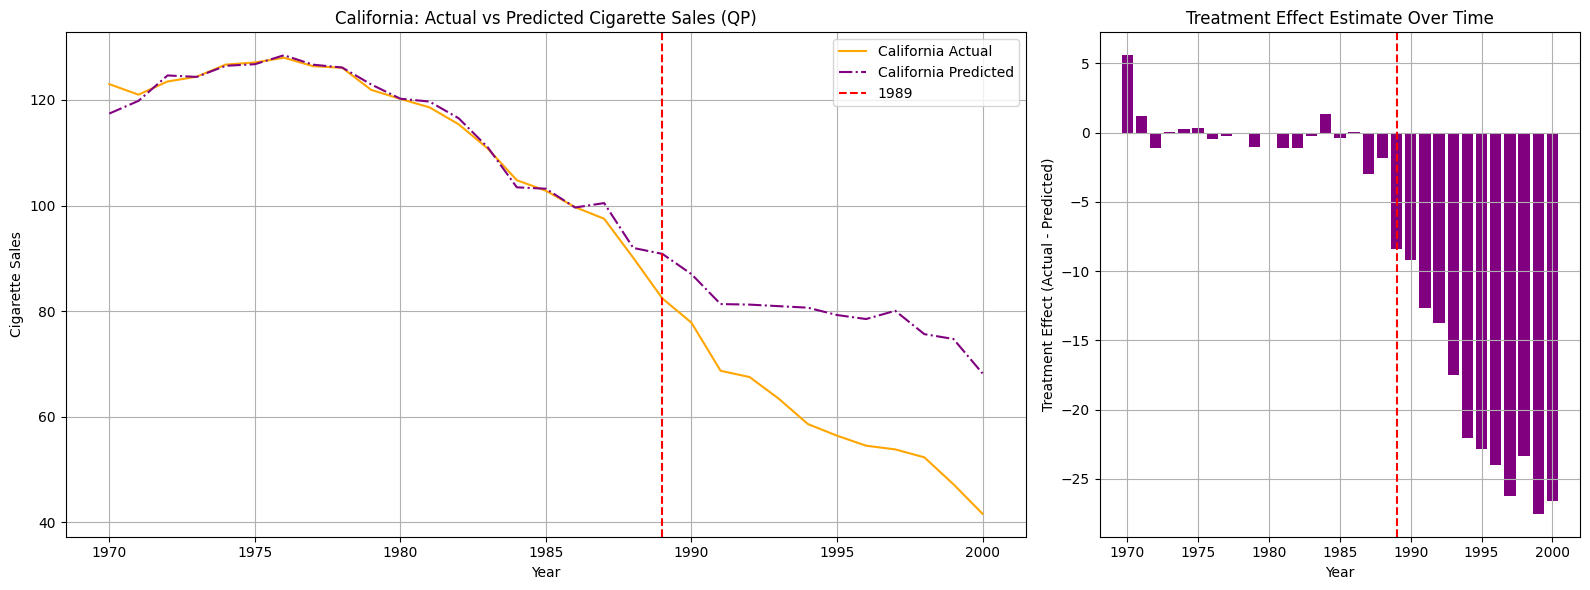

[('Colorado', 0.014810665403002264),
 ('Connecticut', 0.10908960072564813),
 ('Montana', 0.2318402414888415),
 ('Nevada', 0.20492269582807993),
 ('New Hampshire', 0.045428947367578514),
 ('Utah', 0.39390785378218124)]

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers

# Suppress solver output
solvers.options['show_progress'] = False

df = pd.read_csv(path)
pivot_df = df.pivot(index='state', columns='year', values='cigsale')
pre_period_years = pivot_df.columns[pivot_df.columns < 1989]
X_pre = pivot_df.drop(index='California')[pre_period_years].T.values
y_pre = pivot_df.loc['California', pre_period_years].T.values
J = X_pre.shape[1]
Q = 2 * matrix(np.dot(X_pre.T, X_pre))
p = -2 * matrix(np.dot(X_pre.T, y_pre))
G = matrix(-np.eye(J))  # Enforcing w_k >= 0 for all k
h = matrix(np.zeros(J))
A = matrix(1.0, (1, J))  # Enforcing sum of weights equals 1
b = matrix(1.0)
sol = solvers.qp(Q, p, G, h, A, b)
w_optimal = np.array(sol['x']).flatten()

california_predictions_qp = np.dot(X_pre, w_optimal)
full_predictions_qp = np.dot(pivot_df.drop(index='California').T.values, w_optimal)

# Calculate treatment effect
california_actual = pivot_df.loc['California'].values
treatment_effect = california_actual - full_predictions_qp

# Extract donor states and their corresponding weights
donor_states = pivot_df.drop(index='California').index
non_zero_weights = [(state, weight) for state, weight in zip(donor_states, w_optimal) if weight > 1e-5]

# Plot 1: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

axes[0].plot(pivot_df.columns, california_actual, label='California Actual', color='orange')
axes[0].plot(pivot_df.columns, full_predictions_qp, label='California Predicted', color='purple', linestyle='-.')
axes[0].axvline(x=1989, color='red', linestyle='--', label='1989')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Cigarette Sales')
axes[0].set_title('California: Actual vs Predicted Cigarette Sales (QP)')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Treatment Effect Estimate
axes[1].bar(pivot_df.columns, treatment_effect, color='purple')
axes[1].axvline(x=1989, color='red', linestyle='--', label='1989')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Treatment Effect (Actual - Predicted)')
axes[1].set_title('Treatment Effect Estimate Over Time')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Output significant donor weights
non_zero_weights


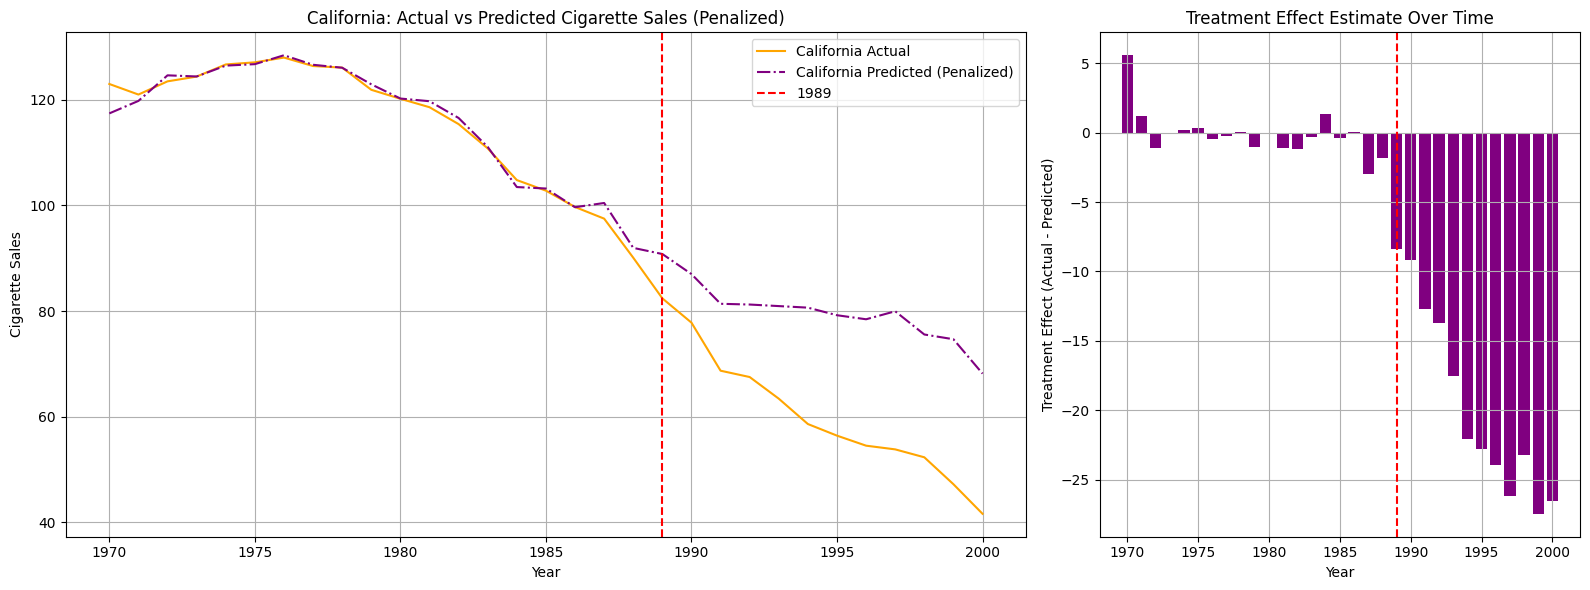

[('Colorado', 0.02354764309947093),
 ('Connecticut', 0.10832201147316951),
 ('Montana', 0.22679397172900473),
 ('Nevada', 0.20494887002798515),
 ('New Hampshire', 0.04420896859101759),
 ('Utah', 0.3921787476232042)]

In [62]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers

# Suppress cvxopt solver output
solvers.options['show_progress'] = False

# Load data
df = pd.read_csv(path)
pivot_df = df.pivot(index='state', columns='year', values='cigsale')

# Define the treatment year and pre-treatment years
treatment_year = 1989
pre_period_years = pivot_df.columns[pivot_df.columns < treatment_year]
post_period_years = pivot_df.columns[pivot_df.columns >= treatment_year]

# Define the penalty parameter lambda
lambda_ = 10

# Extract data for California (treated unit) and other states (donor pool)
X_pre = pivot_df.drop(index='California')[pre_period_years].T.values
y_pre = pivot_df.loc['California', pre_period_years].T.values
covariates = X_pre.T  # Assuming covariates are donor pre-treatment outcomes

# Number of donor units
J = X_pre.shape[1]

# Construct Q matrix for penalized synthetic control
Q = 2 * matrix(np.dot(X_pre.T, X_pre) + lambda_ * np.identity(J))
p = -2 * matrix(np.dot(X_pre.T, y_pre))

# Constraints: W >= 0 and sum(W) = 1
G = matrix(-np.eye(J))  # Non-negativity constraint
h = matrix(np.zeros(J))
A = matrix(1.0, (1, J))  # Sum-to-one constraint
b = matrix(1.0)

# Solve the quadratic programming problem
sol = solvers.qp(Q, p, G, h, A, b)
w_optimal = np.array(sol['x']).flatten()

# Calculate synthetic control for California
california_predictions_penalized = np.dot(pivot_df.drop(index='California').T.values, w_optimal)

# Calculate treatment effect
california_actual = pivot_df.loc['California'].values
treatment_effect = california_actual - california_predictions_penalized

# Extract donor states and their corresponding weights
donor_states = pivot_df.drop(index='California').index
non_zero_weights = [(state, weight) for state, weight in zip(donor_states, w_optimal) if weight > 1e-5]

# Plot 1: Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [2, 1]})

axes[0].plot(pivot_df.columns, california_actual, label='California Actual', color='orange')
axes[0].plot(pivot_df.columns, california_predictions_penalized, label='California Predicted (Penalized)', color='purple', linestyle='-.')
axes[0].axvline(x=1989, color='red', linestyle='--', label='1989')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Cigarette Sales')
axes[0].set_title('California: Actual vs Predicted Cigarette Sales (Penalized)')
axes[0].legend()
axes[0].grid(True)

# Plot 2: Treatment Effect Estimate
axes[1].bar(pivot_df.columns, treatment_effect, color='purple')
axes[1].axvline(x=1989, color='red', linestyle='--', label='1989')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Treatment Effect (Actual - Predicted)')
axes[1].set_title('Treatment Effect Estimate Over Time')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Output significant donor weights
non_zero_weights

### Placebo Test

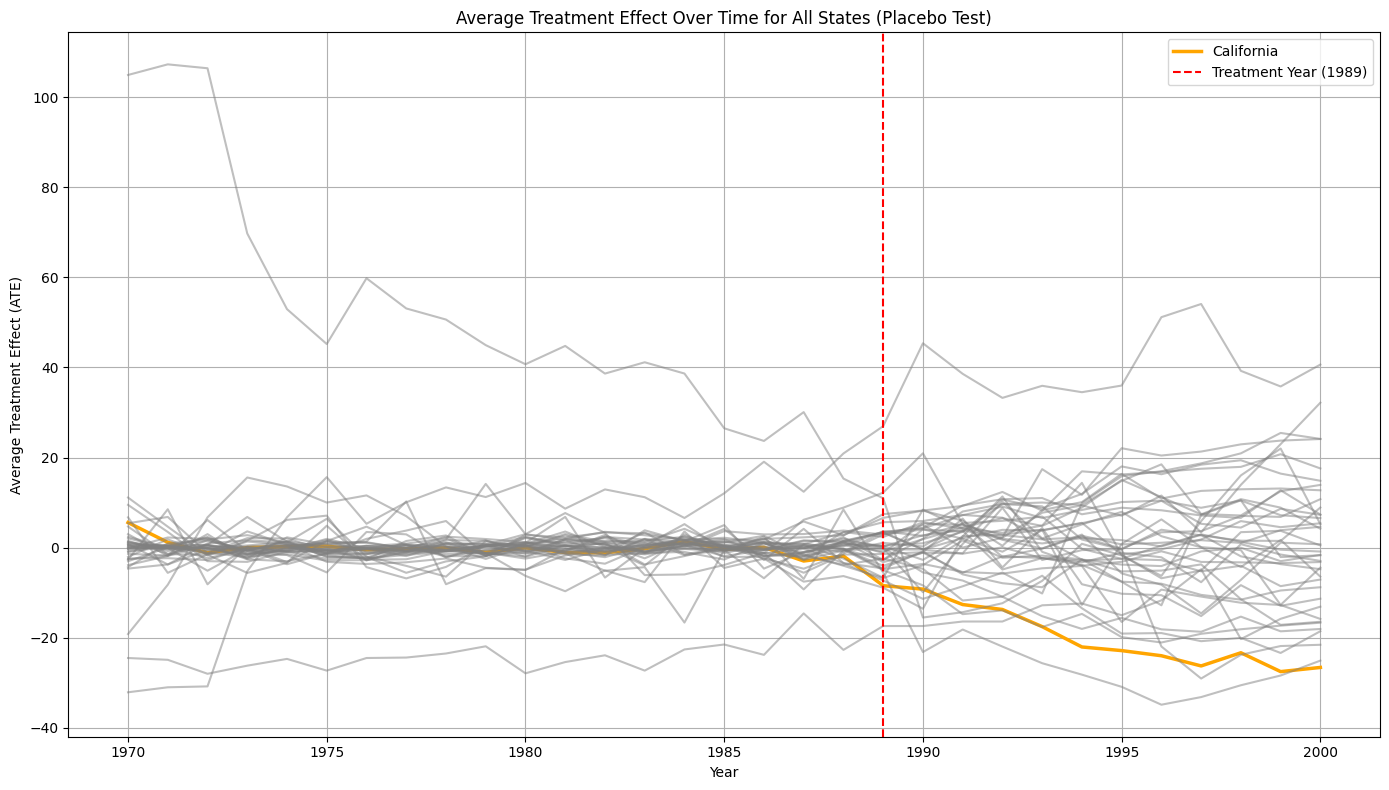

In [59]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers

# Suppress cvxopt solver output
solvers.options['show_progress'] = False

# Load data
df = pd.read_csv(path)
pivot_df = df.pivot(index='state', columns='year', values='cigsale')

# Define the treatment year and pre-treatment years
treatment_year = 1989
pre_period_years = pivot_df.columns[pivot_df.columns < treatment_year]
post_period_years = pivot_df.columns[pivot_df.columns >= treatment_year]

# Function to compute synthetic control and ATE for a given state
def compute_synthetic_control(state_index):
    # Actual data for the state
    Y_actual = pivot_df.loc[state_index].values  # Shape (T_total,)
    Y_actual_pre = pivot_df.loc[state_index, pre_period_years].values  # Shape (T_pre,)
    donor_states = pivot_df.drop(index=state_index)
    Y_donors_pre = donor_states[pre_period_years].values.T  # Shape (T_pre, J)
    Y_donors_full = donor_states.values.T  # Shape (T_total, J)
    Q = 2 * matrix(np.dot(Y_donors_pre.T, Y_donors_pre))
    p = -2 * matrix(np.dot(Y_donors_pre.T, Y_actual_pre))
    J = Y_donors_pre.shape[1]  # Number of donor states
    G = matrix(-np.eye(J))  # Enforcing weights >= 0
    h = matrix(np.zeros(J))
    A = matrix(1.0, (1, J))  # Sum of weights equals 1
    b = matrix(1.0)
    sol = solvers.qp(Q, p, G, h, A, b)
    w_optimal = np.array(sol['x']).flatten()
    Y_synth = np.dot(Y_donors_full, w_optimal)  # Shape (T_total,)
    ATE = Y_actual - Y_synth  # Shape (T_total,)
    return ATE

# Compute the ATE for all states
ATEs = {}
for state in pivot_df.index:
    ATEs[state] = compute_synthetic_control(state)

# Identify California's index (assuming 'California' is the state name)
# If states are indexed by numbers, adjust accordingly
california_state = 'California'  # Replace with the actual identifier if different
if california_state not in pivot_df.index:
    # If 'state' is indexed by numbers and California is index 3 as in original code
    california_state = 'California'

ATE_california = ATEs[california_state]

# Plot all ATEs together, highlighting California
plt.figure(figsize=(14, 8))
for state, ATE in ATEs.items():
    if state == california_state:
        plt.plot(pivot_df.columns, ATE, label='California', color='orange', linewidth=2.5)
    else:
        plt.plot(pivot_df.columns, ATE, color='grey', alpha=0.5)

plt.axvline(x=treatment_year, color='red', linestyle='--', label='Treatment Year (1989)')
plt.xlabel('Year')
plt.ylabel('Average Treatment Effect (ATE)')
plt.title('Average Treatment Effect Over Time for All States (Placebo Test)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

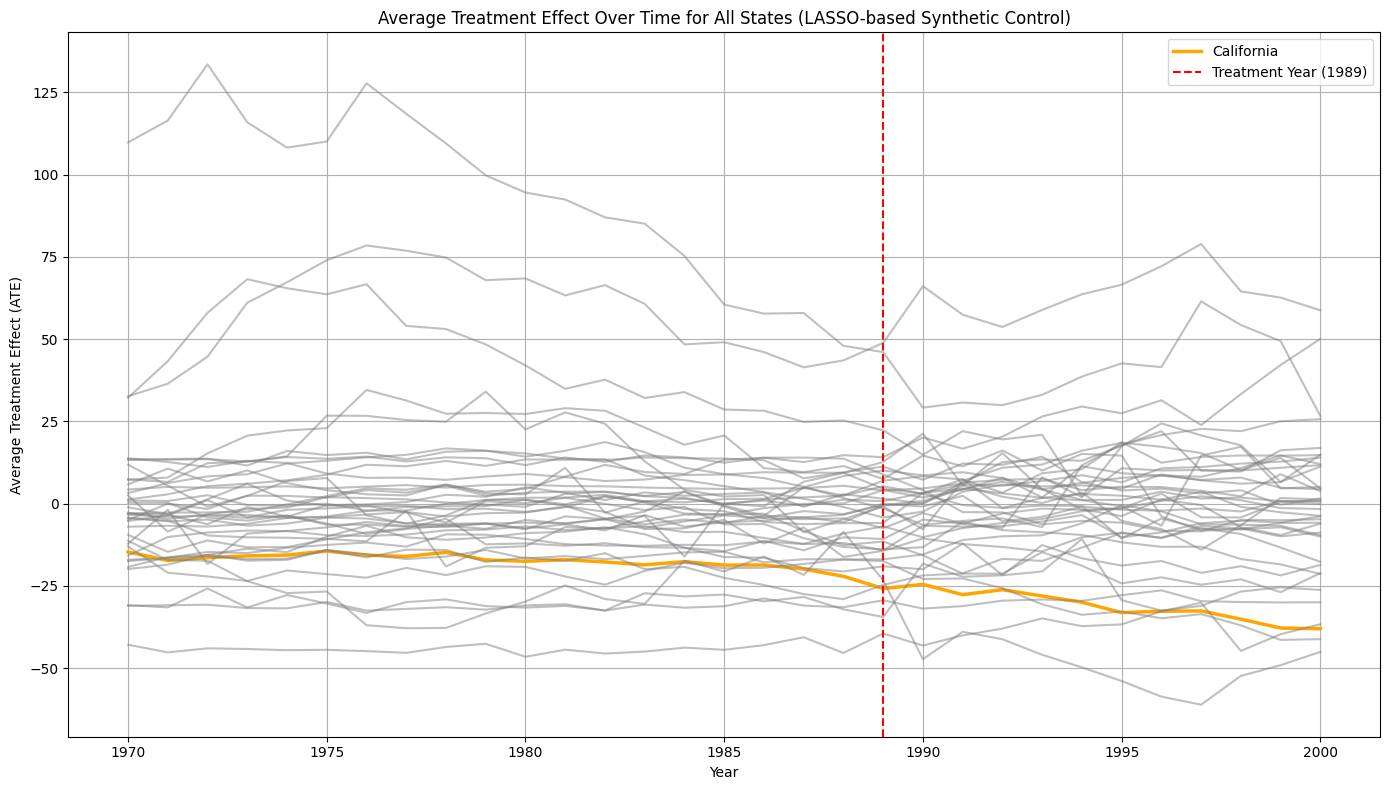

In [52]:
from sklearn.linear_model import Lasso
import numpy as np

# Define treatment year
treatment_year = 1989
pre_period_years = pivot_df.columns[pivot_df.columns < treatment_year]

# Define the regularization parameter
lambda_ = 0.0001

# Initialize a dictionary to store ATEs for all states
ATEs = {}

# Loop over each state
for state in pivot_df.index:
    # Exclude the current state from the donor pool
    X_pre = pivot_df.drop(index=state)[pre_period_years].T  # Donor states (T_pre, J)
    y_pre = pivot_df.loc[state, pre_period_years].T  # Current state's pre-period data (T_pre,)

    # Train a LASSO model
    lasso_model = Lasso(alpha=lambda_, positive=False).fit(X_pre, y_pre)
    w_optimal = lasso_model.coef_
    
    # Normalize weights to ensure they sum to 1
    #if w_optimal.sum() > 0:
    #    w_optimal /= w_optimal.sum()
    
    # Predict the synthetic control for the entire time series
    Y_donors = pivot_df.drop(index=state).T.values  # Entire donor matrix (T_total, J)
    synthetic_control = np.dot(Y_donors, w_optimal)
    
    # Compute the Average Treatment Effect (ATE)
    Y_actual = pivot_df.loc[state].values  # Entire actual data for the state (T_total,)
    ATE = Y_actual - synthetic_control  # ATE for all time periods
    
    # Store ATE for this state
    ATEs[state] = ATE

# Compute the ATE for all states
ATEs = {}
for state in pivot_df.index:
    ATEs[state] = compute_synthetic_control_lasso(state)

# Identify California's index (assuming 'California' is the state name)
california_state = 'California'  # Replace with the actual identifier if different
ATE_california = ATEs[california_state]

# Plot all ATEs together, highlighting California
plt.figure(figsize=(14, 8))
for state, ATE in ATEs.items():
    if state == california_state:
        plt.plot(pivot_df.columns, ATE, label='California', color='orange', linewidth=2.5)
    else:
        plt.plot(pivot_df.columns, ATE, color='grey', alpha=0.5)

plt.axvline(x=treatment_year, color='red', linestyle='--', label='Treatment Year (1989)')
plt.xlabel('Year')
plt.ylabel('Average Treatment Effect (ATE)')
plt.title('Average Treatment Effect Over Time for All States (LASSO-based Synthetic Control)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

{'Alabama': array([-4.64770923, -3.73182175, -0.51136468, -1.57427491,  0.62143649,
        0.77279337,  1.21007929, -0.19792942,  2.44274221,  1.91800038,
        1.22567826, -0.92258211, -0.49102145, -1.49034473, -0.30702038,
       -0.79454959,  1.27124518, -0.12173649,  2.32410013, -2.77788471,
        4.07055539,  1.97543407, -0.9016938 ,  3.8790722 ,  5.51164688,
       -1.55971511, -0.37613708,  1.81622324,  5.89468835,  4.54227211,
        5.41073391]), 'Arkansas': array([ 2.06921333, -0.08977883, -5.11833306, -0.30329221, -3.6765459 ,
       -1.25633697, -1.39493219, -0.3575197 ,  0.98264891,  0.61288365,
        3.00427865,  1.6450825 , -1.34602017,  1.94857404,  1.28117718,
        1.25773063,  1.05375283, -2.5835527 ,  1.53572754,  0.32225444,
       -2.72031062,  2.50762155, 11.36239497, -0.92605718, -4.01115966,
       -3.14419035, -0.80329051, -3.16990349, -3.25967645, -3.42904629,
       -3.19188875]), 'California': array([  5.57595598,   1.17701053,  -1.14640853,   0.0

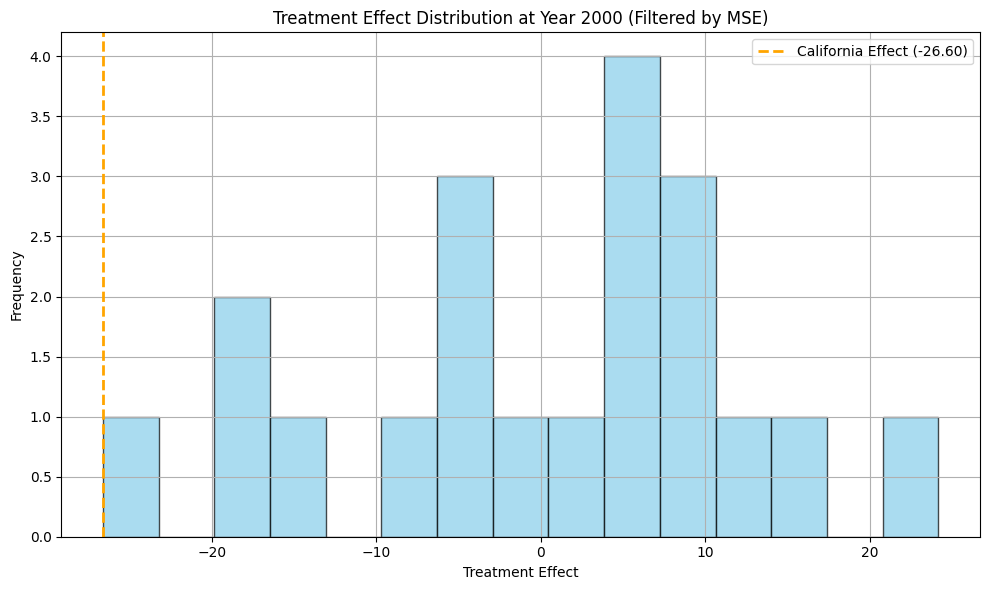

P-value for California's treatment effect being above zero at year 2000 (Filtered): 0.9500
Number of states dropped due to high pre-period MSE: 19


In [42]:
# Define MSE threshold for filtering states with poor pre-period fit
mse_threshold = 5  # Adjust this threshold based on your requirements

# Function to compute synthetic control, ATE, and pre-period MSE for a given state
def compute_synthetic_control_with_mse(state_index):
    Y_actual = pivot_df.loc[state_index].values
    Y_actual_pre = pivot_df.loc[state_index, pre_period_years].values
    
    donor_states = pivot_df.drop(index=state_index)
    Y_donors_pre = donor_states[pre_period_years].values.T
    Y_donors_full = donor_states.values.T
    
    Q = 2 * matrix(np.dot(Y_donors_pre.T, Y_donors_pre))
    p = -2 * matrix(np.dot(Y_donors_pre.T, Y_actual_pre))
    
    J = Y_donors_pre.shape[1]
    G = matrix(-np.eye(J))
    h = matrix(np.zeros(J))
    A = matrix(1.0, (1, J))
    b = matrix(1.0)
    
    sol = solvers.qp(Q, p, G, h, A, b)
    w_optimal = np.array(sol['x']).flatten()
    
    Y_synth = np.dot(Y_donors_full, w_optimal)
    
    # Calculate MSE in the pre-period
    Y_synth_pre = np.dot(Y_donors_pre, w_optimal)
    mse_pre = np.mean((Y_actual_pre - Y_synth_pre) ** 2)
    
    ATE = Y_actual - Y_synth
    
    return ATE, mse_pre

# Compute ATE and pre-period MSE for all states, filtering by MSE threshold
ATEs_filtered = {}
for state in pivot_df.index:
    ATE, mse_pre = compute_synthetic_control_with_mse(state)
    if mse_pre <= mse_threshold:
        ATEs_filtered[state] = ATE
print(ATEs_filtered)

# Check if California passed the MSE filter
if california_state in ATEs_filtered:
    ATE_california_filtered = ATEs_filtered[california_state]

    # Extract treatment effects at the test year for states passing the filter
    test_year = 2000
    test_year_index = list(pivot_df.columns).index(test_year)
    treatment_effects_at_test_year_filtered = np.array([ATE[test_year_index] for ATE in ATEs_filtered.values()])
    california_effect_at_test_year_filtered = ATE_california_filtered[test_year_index]

    # Plot distribution of treatment effects at the test year for filtered states
    plt.figure(figsize=(10, 6))
    plt.hist(treatment_effects_at_test_year_filtered, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
    plt.axvline(california_effect_at_test_year_filtered, color='orange', linestyle='--', linewidth=2, label=f'California Effect ({california_effect_at_test_year_filtered:.2f})')
    plt.title(f'Treatment Effect Distribution at Year {test_year} (Filtered by MSE)')
    plt.xlabel('Treatment Effect')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Test the p-value for California's treatment effect being above zero (filtered)
    p_value_filtered = (treatment_effects_at_test_year_filtered > california_effect_at_test_year_filtered).mean()
    print(f'P-value for California\'s treatment effect being above zero at year {test_year} (Filtered): {p_value_filtered:.4f}')
else:
    print(f'California did not pass the MSE filter (Threshold: {mse_threshold})')

# Count the number of states dropped based on the MSE threshold
dropped_states_count = len(pivot_df) - len(ATEs_filtered)
print(f'Number of states dropped due to high pre-period MSE: {dropped_states_count}')

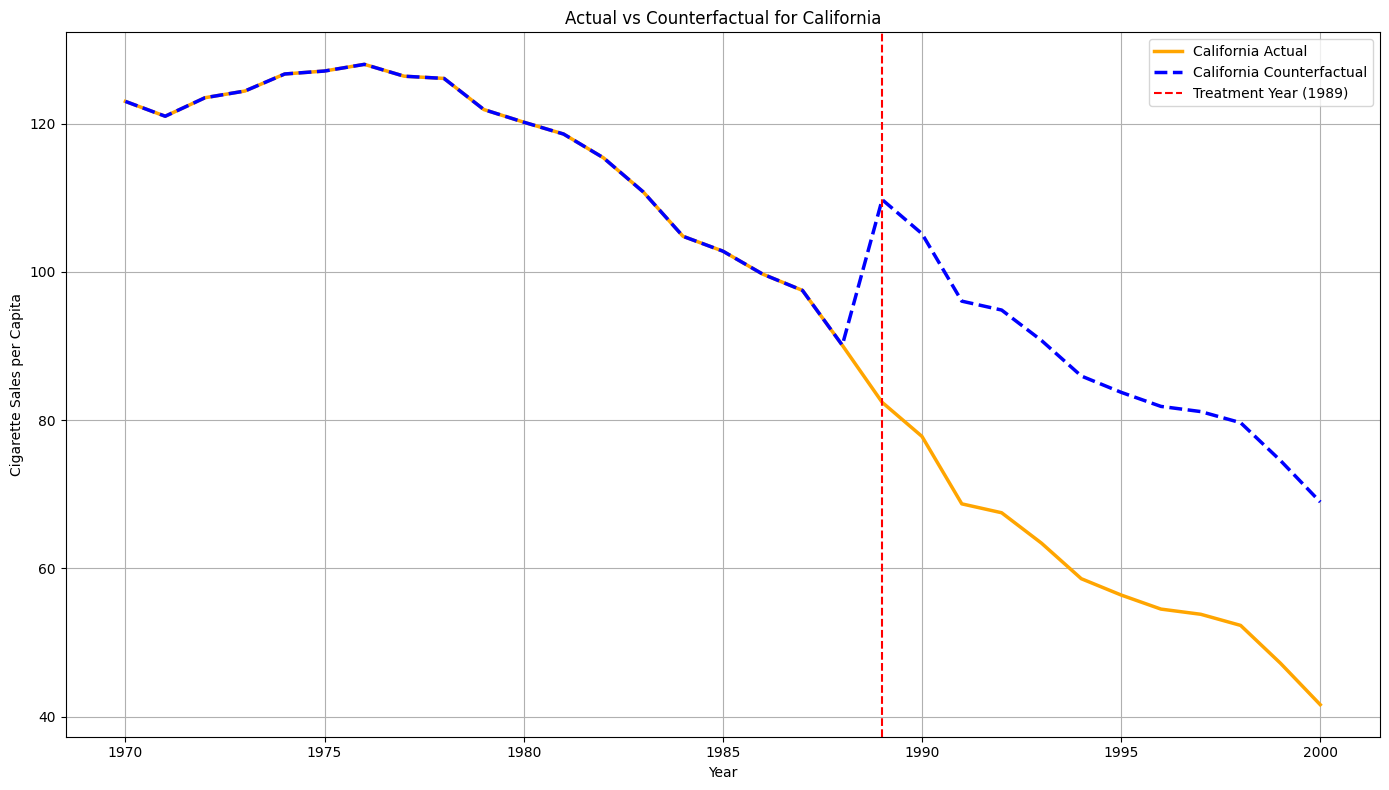

,state,year,Y_it,D_it,Y_demeaned,D_demeaned,Y_counterfactual
2,3,1970,123.000000,0,27.147145,-0.377171,123.000000
41,3,1971,121.000000,0,21.516377,-0.377171,121.000000
80,3,1972,123.500000,0,18.772787,-0.377171,123.500000
119,3,1973,124.400002,0,17.349712,-0.377171,124.400002
158,3,1974,126.699997,0,16.542016,-0.377171,126.699997


In [15]:
# Updating the code with the loaded dataset
# Pivot the dataframe to create the pivot_df similar to the original code

pivot_df = df.pivot(index='state', columns='year', values='cigsale')

# Step 1: Create dataset in long format
df_long = pivot_df.reset_index().melt(id_vars=['state'], var_name='year', value_name='Y_it')
df_long['D_it'] = ((df_long['state'] == 3) & (df_long['year'] >= 1989)).astype(int)  # California indexed by 3

# Step 2: Double demean the variables Y_it and D_it
mean_Y_over_states = df_long.groupby('year')['Y_it'].transform('mean')
mean_Y_over_years = df_long.groupby('state')['Y_it'].transform('mean')
df_long['Y_demeaned'] = df_long['Y_it'] - mean_Y_over_states - mean_Y_over_years + df_long['Y_it'].mean()

mean_D_over_states = df_long.groupby('year')['D_it'].transform('mean')
mean_D_over_years = df_long.groupby('state')['D_it'].transform('mean')
df_long['D_demeaned'] = df_long['D_it'] - mean_D_over_states - mean_D_over_years + df_long['D_it'].mean()

# Step 3: Simple regression of double demeaned Y_it on double demeaned D_it
from statsmodels.api import OLS, add_constant

X = add_constant(df_long['D_demeaned'])
model = OLS(df_long['Y_demeaned'], X).fit()
tau = model.params['D_demeaned']

# Step 4: Predict counterfactual for California using tau
# Extract the actual values for California
california_data = df_long[df_long['state'] == 3].copy()
california_data['Y_counterfactual'] = california_data['Y_it'] - california_data['D_it'] * tau

# Plot the actual and counterfactual for California
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.plot(california_data['year'], california_data['Y_it'], label='California Actual', color='orange', linewidth=2.5)
plt.plot(california_data['year'], california_data['Y_counterfactual'], label='California Counterfactual', color='blue', linestyle='--', linewidth=2.5)
plt.axvline(x=1989, color='red', linestyle='--', label='Treatment Year (1989)')
plt.xlabel('Year')
plt.ylabel('Cigarette Sales per Capita')
plt.title('Actual vs Counterfactual for California')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Displaying the dataframe to verify California data
california_data.head()


### Synthetic Control Design

- A ridesharing company in the US wants to assess the impact of a new pay program with higher incentives for drivers.
- Challenges with Randomized Control Trials (RCTs) at Driver Level:
    - Unfair
    - Congestion (spillovers)
- Standard Solution: Randomize Across Cities
    - Equity concern
    - Drivers in treated cities may be disappointed if the program is later rolled back.
    - Small number of cities may reduce the effectiveness of randomization.
- Solution: Treat one city or a few cities as the pilot program and use others as controls.
    - Treated cities must represent the broader set of cities of interest.
    - Treated and control cities should not differ significantly in characteristics.
- Synthetic Control Design Goals:
    - Treated unit(s) should represent features of the aggregate of interest (e.g., the country).
    - Treated unit(s) should not be idiosyncratic and should be approximable by control units.


Step 1: Data generated.
Step 2: Treatment assigned. Treated unit: 0
Step 3: Predictors constructed.
Step 4: Synthetic control weights calculated.
Weights for control units: [5.27383623e-08 2.33367539e-02 4.55197896e-01 3.12977703e-01
 1.30523746e-07 3.18959371e-09 2.47052820e-08 1.01693427e-08
 2.08487426e-01]
Step 5: Synthetic control outcomes computed.
Step 6: Treatment effect estimated.
Estimated average treatment effect: 4.5472
True treatment effect (theta): 5.0000
Pass: Estimated treatment effect is within tolerance.
Step 7: RMSPE computed.
Pre-treatment RMSPE: 1.5677
Post-treatment RMSPE: 4.8804
Fail: Pre-treatment RMSPE is too high.


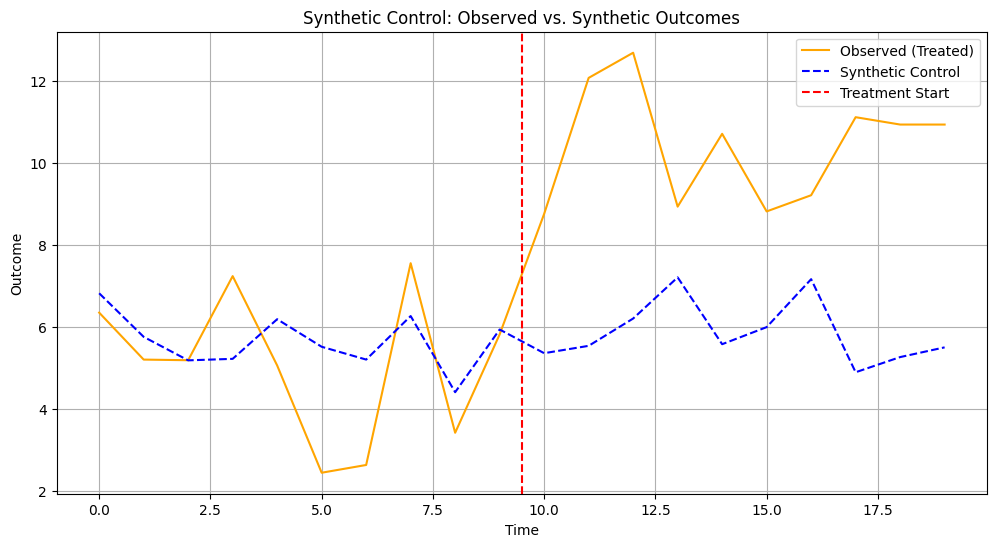

Step 8: Results plotted.


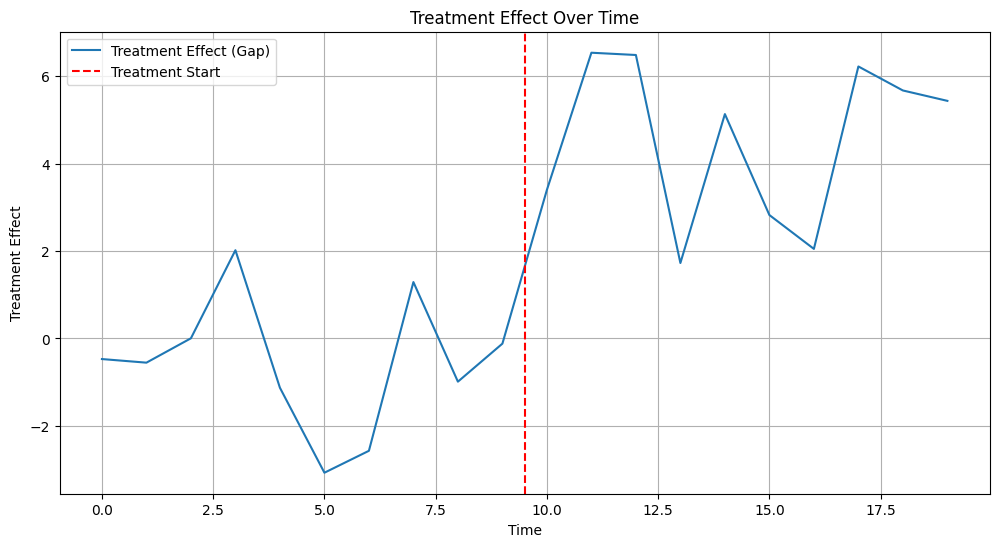

Step 9: Treatment effect over time plotted.
Step 10: Treatment effects data frame created.
    Time   Observed  Synthetic  Treatment Effect
0      0   6.344486   6.816566         -0.472079
1      1   5.199205   5.753753         -0.554548
2      2   5.183473   5.180456          0.003017
3      3   7.235059   5.217395          2.017664
4      4   5.055855   6.183969         -1.128114
5      5   2.439700   5.512043         -3.072343
6      6   2.628635   5.199620         -2.570985
7      7   7.550114   6.261109          1.289005
8      8   3.414481   4.403964         -0.989483
9      9   5.813644   5.933066         -0.119422
10    10   8.753680   5.355376          3.398304
11    11  12.070216   5.534588          6.535628
12    12  12.684228   6.200670          6.483559
13    13   8.929926   7.204855          1.725070
14    14  10.706252   5.574566          5.131685
15    15   8.813383   5.990827          2.822556
16    16   9.208202   7.160421          2.047781
17    17  11.111608   4.890

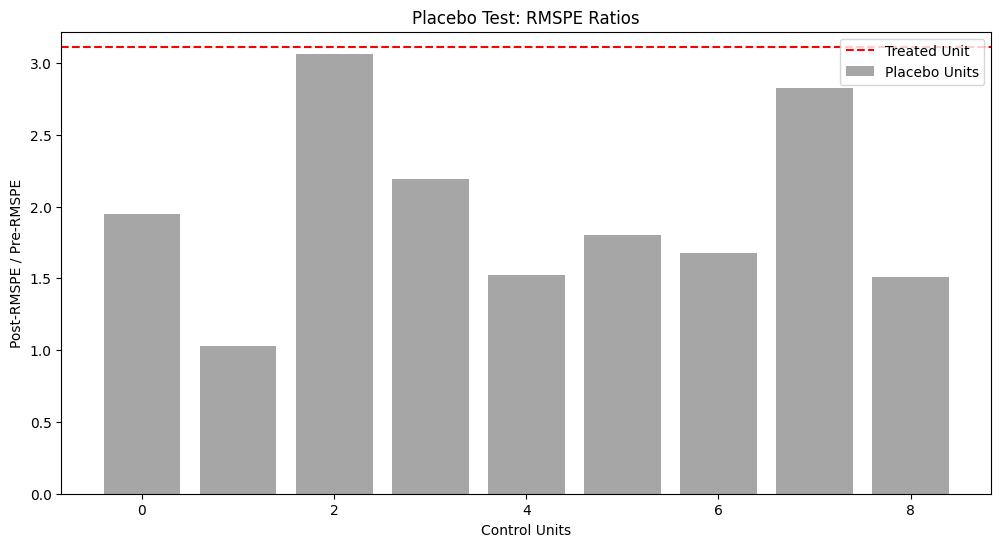

Step 12: Placebo test results plotted.


In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers

solvers.options['show_progress'] = False
np.random.seed(42)

# Step 1: Generate Data
def generate_data(J, T, T0, a, b, c, theta, noise_std=1.0):
    X = np.random.rand(J, T)
    E = np.random.rand(J, T)
    Y_untreated = a + b * X + c * E + np.random.normal(0, noise_std, size=(J, T))
    Y_treated = np.copy(Y_untreated)
    Y_treated[0, T0:] += theta
    return X, E, Y_untreated, Y_treated

J = 10
T = 20
T0 = 10
a, b, c = 2, 3, 4
theta = 5
noise_std = 0.5

X, E, Y_untreated, Y_treated = generate_data(J, T, T0, a, b, c, theta, noise_std)
print("Step 1: Data generated.")

# Step 2: Assign Treatment
treated_unit = 0
control_units = list(range(1, J))
print("Step 2: Treatment assigned. Treated unit:", treated_unit)

# Step 3: Construct Predictors
def construct_predictors(Y, X, T0):
    predictors_Y = Y[:, :T0]
    predictors_X = X[:, :T0]
    predictors = np.hstack([predictors_Y, predictors_X])
    return predictors

predictors = construct_predictors(Y_untreated, X, T0)
print("Step 3: Predictors constructed.")

# Step 4: Solve for Synthetic Control Weights
def solve_synthetic_control(treated_predictor, control_predictors):
    J_control = control_predictors.shape[0]
    V = np.identity(treated_predictor.shape[0])
    X0 = control_predictors.T
    X1 = treated_predictor
    Q = 2 * matrix(np.dot(X0.T, np.dot(V, X0)))
    p = -2 * matrix(np.dot(X0.T, np.dot(V, X1)))
    G = matrix(-np.eye(J_control))
    h = matrix(np.zeros(J_control))
    A = matrix(1.0, (1, J_control))
    b = matrix(1.0)
    sol = solvers.qp(Q, p, G, h, A, b)
    weights = np.array(sol['x']).flatten()
    return weights

treated_predictor = predictors[treated_unit]
control_predictors = predictors[control_units]
weights = solve_synthetic_control(treated_predictor, control_predictors)
print("Step 4: Synthetic control weights calculated.")
print("Weights for control units:", weights)

# Step 5: Compute Synthetic Control Outcomes
def compute_synthetic_control_outcomes(weights, control_outcomes):
    Y0 = control_outcomes.T
    Y_synth = np.dot(Y0, weights)
    return Y_synth

control_outcomes = Y_untreated[control_units]
synthetic_control_outcomes = compute_synthetic_control_outcomes(weights, control_outcomes)
print("Step 5: Synthetic control outcomes computed.")

# Step 6: Estimate Treatment Effect
observed_outcomes = Y_treated[treated_unit]
treatment_effect = observed_outcomes - synthetic_control_outcomes
print("Step 6: Treatment effect estimated.")

# Pass/Fail Check: Compare estimated average treatment effect to true theta
estimated_theta = np.mean(treatment_effect[T0:])
print(f"Estimated average treatment effect: {estimated_theta:.4f}")
print(f"True treatment effect (theta): {theta:.4f}")

# Define a tolerance level
tolerance = 0.5
if np.abs(estimated_theta - theta) <= tolerance:
    print("Pass: Estimated treatment effect is within tolerance.")
else:
    print("Fail: Estimated treatment effect is outside tolerance.")

# Step 7: Compute RMSPE for Pre-treatment and Post-treatment Periods
def compute_rmspe(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

pre_rmspe = compute_rmspe(observed_outcomes[:T0], synthetic_control_outcomes[:T0])
post_rmspe = compute_rmspe(observed_outcomes[T0:], synthetic_control_outcomes[T0:])
print("Step 7: RMSPE computed.")
print(f"Pre-treatment RMSPE: {pre_rmspe:.4f}")
print(f"Post-treatment RMSPE: {post_rmspe:.4f}")

# Additional Pass/Fail Check: Pre-treatment fit should be good
max_pre_rmspe = 1.0  # Define acceptable pre-treatment RMSPE
if pre_rmspe <= max_pre_rmspe:
    print("Pass: Pre-treatment RMSPE is within acceptable range.")
else:
    print("Fail: Pre-treatment RMSPE is too high.")

# Step 8: Plot Results
plt.figure(figsize=(12, 6))
plt.plot(range(T), observed_outcomes, label="Observed (Treated)", color='orange')
plt.plot(range(T), synthetic_control_outcomes, label="Synthetic Control", color='blue', linestyle='--')
plt.axvline(x=T0 - 0.5, color='red', linestyle='--', label="Treatment Start")
plt.xlabel("Time")
plt.ylabel("Outcome")
plt.title("Synthetic Control: Observed vs. Synthetic Outcomes")
plt.legend()
plt.grid()
plt.show()
print("Step 8: Results plotted.")

# Step 9: Plot Treatment Effect Over Time
plt.figure(figsize=(12, 6))
plt.plot(range(T), treatment_effect, label="Treatment Effect (Gap)")
plt.axvline(x=T0 - 0.5, color='red', linestyle='--', label="Treatment Start")
plt.xlabel("Time")
plt.ylabel("Treatment Effect")
plt.title("Treatment Effect Over Time")
plt.legend()
plt.grid()
plt.show()
print("Step 9: Treatment effect over time plotted.")

# Step 10: Output Treatment Effects
treatment_effect_df = pd.DataFrame({
    'Time': range(T),
    'Observed': observed_outcomes,
    'Synthetic': synthetic_control_outcomes,
    'Treatment Effect': treatment_effect
})
print("Step 10: Treatment effects data frame created.")
print(treatment_effect_df)

# Step 11: Conduct Placebo Tests
def placebo_test(control_units, predictors, Y_untreated, T0):
    placebo_rmspe_ratios = []
    for unit in control_units:
        placebo_treated_unit = unit
        placebo_control_units = [u for u in control_units if u != unit]
        placebo_treated_predictor = predictors[placebo_treated_unit]
        placebo_control_predictors = predictors[placebo_control_units]
        placebo_weights = solve_synthetic_control(placebo_treated_predictor, placebo_control_predictors)
        placebo_control_outcomes = Y_untreated[placebo_control_units]
        placebo_synthetic_outcomes = compute_synthetic_control_outcomes(placebo_weights, placebo_control_outcomes)
        placebo_observed_outcomes = Y_untreated[placebo_treated_unit]
        placebo_pre_rmspe = compute_rmspe(placebo_observed_outcomes[:T0], placebo_synthetic_outcomes[:T0])
        placebo_post_rmspe = compute_rmspe(placebo_observed_outcomes[T0:], placebo_synthetic_outcomes[T0:])
        rmspe_ratio = placebo_post_rmspe / placebo_pre_rmspe if placebo_pre_rmspe != 0 else np.inf
        placebo_rmspe_ratios.append(rmspe_ratio)
    return placebo_rmspe_ratios

placebo_rmspe_ratios = placebo_test(control_units, predictors, Y_untreated, T0)
print("Step 11: Placebo tests conducted.")
print("Placebo RMSPE Ratios:", placebo_rmspe_ratios)

# Additional Pass/Fail Check: Treatment effect should be unique
treated_rmspe_ratio = post_rmspe / pre_rmspe
higher_count = sum(1 for ratio in placebo_rmspe_ratios if ratio >= treated_rmspe_ratio)
p_value = higher_count / len(placebo_rmspe_ratios)
print(f"Treated unit RMSPE ratio: {treated_rmspe_ratio:.4f}")
print(f"P-value from placebo tests: {p_value:.4f}")

significance_level = 0.05
if p_value < significance_level:
    print("Pass: Treatment effect is statistically significant.")
else:
    print("Fail: Treatment effect is not statistically significant.")

# Step 12: Plot Placebo Test Results
plt.figure(figsize=(12, 6))
plt.bar(range(len(placebo_rmspe_ratios)), placebo_rmspe_ratios, color='gray', alpha=0.7, label='Placebo Units')
plt.axhline(y=treated_rmspe_ratio, color='red', linestyle='--', label='Treated Unit')
plt.xlabel('Control Units')
plt.ylabel('Post-RMSPE / Pre-RMSPE')
plt.title('Placebo Test: RMSPE Ratios')
plt.legend()
plt.show()
print("Step 12: Placebo test results plotted.")
